In [1]:
import os
import sys

_PATH = '/Users/winston/mygitrep/sys23/'  # TODO
os.chdir(_PATH)
sys.path.append(_PATH)

In [2]:
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
# seaborn.set_style("darkgrid")
seaborn.set_style("whitegrid")
# plt.rc("figure", figsize=(16, 6))
plt.rc("figure", figsize=(8, 4))
plt.rc("savefig", dpi=90)
# plt.rc("font", family="sans-serif")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
# plt.rc("font", size=12)
plt.rc("font", size=10)
plt.rcParams["date.autoformatter.hour"] = "%H:%M:%S"

In [3]:
from api.load_tushare import conf_init, next_calendar_date
import pandas as pd
import numpy as np

config_path = f'{_PATH}/config_stk.yaml'
conf = conf_init(conf_path=config_path)

begin_date = '2015-01-01'
# begin_date = '2015-07-01'
end_date = '2022-12-31'
stk_pool = 'CSI500'
bd_1 = next_calendar_date(begin_date, delta=-5, lfmt='%Y-%m-%d', rfmt='%Y-%m-%d')
conf.keys()

dict_keys(['status', 'tushare_token', 'api_path', 'path', 'year_length', 'csi_pool'])

In [4]:
src_path = conf['path']['demo'] + 'lucky_number/'
assert os.path.exists(src_path)
tgt_path = src_path + f'{stk_pool}/'
os.makedirs(tgt_path, exist_ok=True)
print('\n'.join([_ for _ in os.listdir(src_path) if 'xlsx' == _[-4:]]))

样本数量及其分布_ALL.xlsx
样本数量及其分布_CSI1000.xlsx
回归系数.xlsx
价格尾数（分位）与随后的股票收益率.xlsx
价格尾数（毛、分位）与随后的股票收益率.xlsx
performance_nc.xlsx
样本数量及其分布_CSI500.xlsx


## 策略构建

策略：

本质是面对复杂决策时的思维捷径（Heuristic infomation process）和有限注意力（Inattention）

两种行为机制：

1. 锚定效应（Reference Point）：价格跨越整数后被认为更值钱，3.99上涨到4.00后被认为值更多钱，倾向于买入上涨到4.00的而卖出下跌到3.99的
2. 左位数偏差（Left-digit Bias）：认为价格3.99比价格4.00便宜很多，当价格为4.00是倾向于高位卖出，价格为3.99时倾向于低位买入


几个实证现象：

1. 市面上的股价多以 0 或 5 结尾
2. 收盘价尾数（“角”位和“分”位）00-04，相比尾数95-99：c2o收益率平均更高，c2c收益率平均更低

In [5]:
stk_pool = pd.read_csv(conf['path'][stk_pool], index_col=0, parse_dates=True).loc[bd_1: end_date]
stk_pool = (stk_pool > 0).astype(float)

close_raw: pd.DataFrame = pd.read_csv(conf['path']['close'], index_col=0, parse_dates=True).loc[bd_1: end_date]
close_raw = (stk_pool.reindex_like(close_raw) * close_raw).replace(0, np.nan).dropna(how='all', axis=1)

In [6]:
def f(x):
    if np.isnan(x):
        return x
    xx = x % 1
    if xx < 0.05:
        return '00~04'
    elif  (0.50 <= xx < 0.55):
        return '50~54'
    elif xx > 0.94:
        return '95~99'
    elif (0.45 <= xx < 0.50):
        return '45~49'
    return np.nan

signal_l1 = close_raw.applymap(f).shift(1).loc[begin_date:]

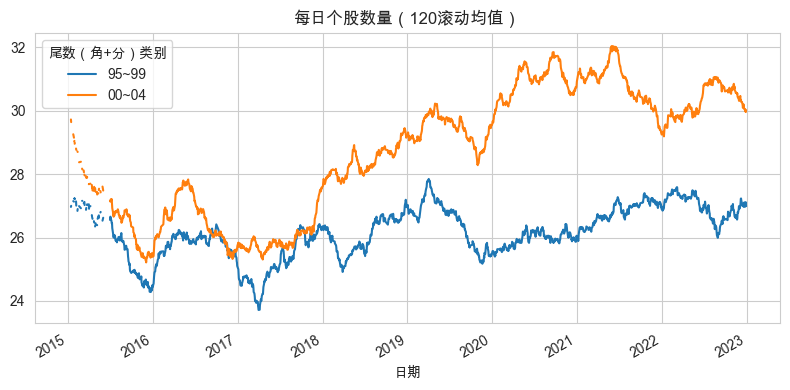

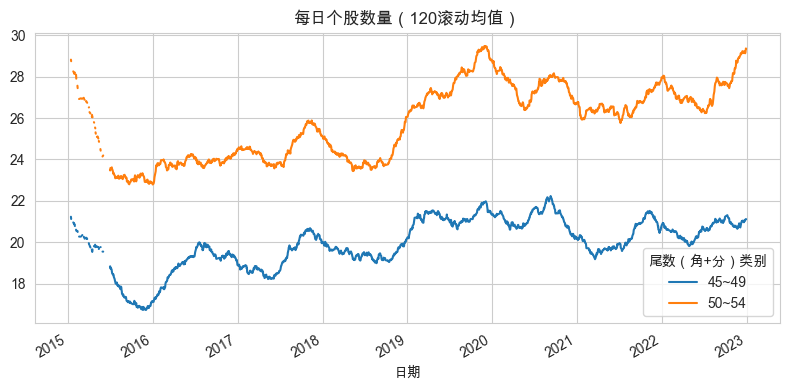

In [7]:
df = pd.DataFrame()
for c in ['95~99', '00~04', '45~49', '50~54']:
    df[c] = (signal_l1 == c).sum(axis=1).rename('个股数量')
df.index.name = '日期'
df.columns.name = '尾数（角+分）类别'
plt.close()
df[['95~99', '00~04']].rolling(120).mean().plot(title='每日个股数量（120滚动均值）')
plt.tight_layout()
plt.savefig(tgt_path + 'Fig1.png', transparent=True)
plt.show()
df[['45~49', '50~54']].rolling(120).mean().plot(title='每日个股数量（120滚动均值）')
plt.tight_layout()
plt.savefig(tgt_path + 'Fig2.png', transparent=True)
plt.show()

holding_weight = df.applymap(lambda x: 1/x if x > 0 else 0)
del df
holding_weight['95~99'] *= 2
holding_weight['00~04'] *= -2
holding_weight['50~54'] *= -1

In [8]:
keep_pool_only = lambda df: (stk_pool.reindex_like(df) * df).replace(0, np.nan).dropna(how='all', axis=1)

close_adj = pd.read_csv(conf['path']['closeAdj'], index_col=0, parse_dates=True).loc[bd_1: end_date]
close_adj = keep_pool_only(close_adj)
open_adj = pd.read_csv(conf['path']['openAdj'], index_col=0, parse_dates=True).loc[bd_1: end_date]
open_adj = keep_pool_only(open_adj)

rtn_o2c = (close_adj / open_adj - 1)

In [9]:
holding_weight.head()

尾数（角+分）类别,95~99,00~04,45~49,50~54
日期,,,,
2015-01-05,0.080000,-0.086957,0.043478,-0.066667
2015-01-06,0.083333,-0.060606,0.071429,-0.035714
2015-01-07,0.062500,-0.064516,0.052632,-0.050000
2015-01-08,0.060606,-0.071429,0.043478,-0.052632
2015-01-09,0.068966,-0.071429,0.041667,-0.050000


In [10]:
holdings = signal_l1.apply(lambda s: s.apply(
    lambda x: holding_weight.loc[s.name, x].values[0] 
    if isinstance(x, str) else np.nan), axis=1).fillna(0)
holdings = holdings.drop_duplicates()
holdings = holdings.apply(lambda s: s / s.abs().sum(), axis=1)
# holdings /= 6
# assert (holdings.abs().sum(axis=1).round(6) == 1).prod() == 1
# assert (holdings.sum(axis=1).round(6) == 0).prod() == 1

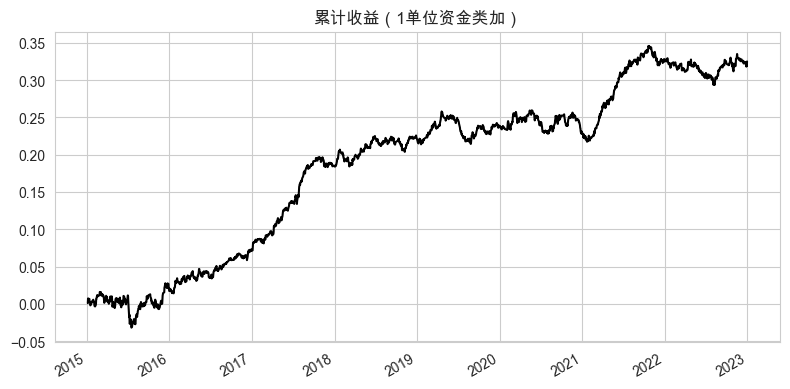

In [11]:
d_rtn = (rtn_o2c.loc[begin_date:] * holdings).sum(axis=1)
cum_rtn = d_rtn.cumsum()
cum_rtn.plot(color='k', title='累计收益（1单位资金类加）')
plt.tight_layout()
plt.savefig(tgt_path + 'Fig3.png', transparent=True)
plt.show()

In [12]:
from api.backtester import cal_result_stat
cal_result_stat?

Signature:
cal_result_stat(
    df: pandas.core.frame.DataFrame,
    save_path: str = None,
    kind='cumsum',
    freq='D',
    lang='EN',
) -> pandas.core.frame.DataFrame
Docstring:
对日度收益序列df计算相关结果
:param lang:
:param df: 值为日收益率小r，列index为日期DateTime
:param save_path: 存储名（若有）
:param kind: 累加/累乘
:param freq: M D W Y
:return: 结果面板
File:      ~/mygitrep/sys23/api/backtester.py
Type:      function

In [13]:
df = cal_result_stat(pd.DataFrame(d_rtn))
df.to_excel(tgt_path + 'performance_nc.xlsx')
df_repr = df.round(3)
df_repr.to_csv(tgt_path + 'performance_nc.csv')
# print(df_repr.to_markdown())
df_repr

,Date,Cash,UnitVal,TRet,PRet,PSharpe,PMaxDD,PCalmar,PWinR,TMaxDD,TSharpe,TCalmar,TWinR,TAnnRet
SemiYear,,,,,,,,,,,,,,
2015-H1,2015-06-30,20188182.9,1.009,0.009,0.009,0.427,-0.022,0.436,0.513,-0.052,1.127,21.578,0.518,0.036
2015-H2,2015-12-31,20347205.9,1.017,0.017,0.008,0.292,-0.048,0.165,0.536,-0.052,1.127,21.578,0.518,0.036
2016-H1,2016-06-30,20698362.9,1.035,0.035,0.017,1.107,-0.013,1.284,0.483,-0.052,1.127,21.578,0.518,0.036
2016-H2,2016-12-30,21422576.7,1.071,0.071,0.035,2.763,-0.013,2.748,0.556,-0.052,1.127,21.578,0.518,0.036
2017-H1,2017-06-30,22723650.4,1.136,0.136,0.061,4.597,-0.007,9.016,0.630,-0.052,1.127,21.578,0.518,0.036
2017-H2,2017-12-29,23692058.4,1.185,0.185,0.043,2.723,-0.014,3.141,0.568,-0.052,1.127,21.578,0.518,0.036
2018-H1,2018-06-29,24440817.1,1.222,0.222,0.032,2.382,-0.023,1.404,0.538,-0.052,1.127,21.578,0.518,0.036
2018-H2,2018-12-28,24474517.6,1.224,0.224,0.001,0.115,-0.021,0.065,0.468,-0.052,1.127,21.578,0.518,0.036
2019-H1,2019-06-28,24927523.3,1.246,0.246,0.019,1.416,-0.016,1.191,0.517,-0.052,1.127,21.578,0.518,0.036


In [14]:
tc = 1e-3

tmp = holdings.diff()
tmp.iloc[0] = holdings.iloc[0].values
(tmp.abs().sum(axis=1) * tc).cumsum()

2015-01-05    0.001000
2015-01-06    0.002812
2015-01-07    0.004675
2015-01-08    0.006463
2015-01-09    0.008179
                ...   
2022-12-26    3.257268
2022-12-27    3.258791
2022-12-28    3.260341
2022-12-29    3.261873
2022-12-30    3.263427
Length: 1947, dtype: float64

## 描述性统计结果

- 观测期：2015-01-01 ~ 2022-12-31
- 股票池：中证500

In [15]:
df = pd.read_excel(src_path + '样本数量及其分布_CSI500.xlsx', index_col=0, header=[0,1])
# df.columns = df.columns.to_series().apply(lambda x: f"{x[1]} {x[0]}")
df_repr = df.applymap(lambda x: str(int(x)) if x > 1 else f'{x * 100:2.1f}%')
df_repr

,出现次数,频率,出现次数,频率,出现次数,频率,出现次数,频率,出现次数,频率,出现次数,频率,出现次数,频率,出现次数,频率
,2015,2015,2016,2016,2017,2017,2018,2018,2019,2019,2020,2020,2021,2021,2022,2022
DP,,,,,,,,,,,,,,,,
0,30656,12.6%,28516,11.7%,28220,11.6%,27690,11.4%,30532,12.5%,32196,13.2%,32900,13.5%,31594,13.1%
1,19910,8.2%,21776,8.9%,21842,9.0%,22672,9.3%,23010,9.4%,22842,9.4%,22908,9.4%,22726,9.4%
2,20016,8.2%,21654,8.9%,21860,9.0%,21322,8.8%,22880,9.4%,22992,9.5%,22686,9.3%,22844,9.4%
3,19092,7.8%,21110,8.7%,21612,8.9%,22622,9.3%,23084,9.5%,22682,9.3%,22484,9.3%,22750,9.4%
4,19170,7.9%,21364,8.8%,21492,8.8%,21672,8.9%,22720,9.3%,21844,9.0%,22096,9.1%,22372,9.2%
5,22512,9.2%,23818,9.8%,23710,9.7%,23936,9.9%,25318,10.4%,25922,10.7%,25454,10.5%,25638,10.6%
6,19082,7.8%,21490,8.8%,21468,8.8%,21624,8.9%,23402,9.6%,22122,9.1%,22722,9.4%,22796,9.4%
7,19916,8.2%,21826,8.9%,22020,9.0%,21312,8.8%,22698,9.3%,22320,9.2%,22212,9.1%,22202,9.2%


In [16]:
df = pd.read_excel(src_path + '价格尾数（分位）与随后的股票收益率.xlsx', index_col=0)
df_repr = df.applymap(lambda x: f'{x*100:2.3f}%' if abs(x) < 0.01 else round(x, 2) if isinstance(x, float) else x)
# print(df_repr.to_markdown())
df_repr

,观测数,C2C_均值,C2C_中位数,C2C_t值,C2O_均值,C2O_中位数,C2O_t值
DP,,,,,,,
0,7748160,-0.021%,-0.235%,-24.34,0.025%,-0.001%,65.87
1,5681280,-0.008%,-0.225%,-8.79,0.037%,0.001%,85.24
2,5635136,-0.003%,-0.237%,-2.63,0.030%,-0.003%,68.31
3,5606912,-0.012%,-0.233%,-12.06,0.030%,-0.004%,67.24
4,5521408,-0.029%,-0.240%,-30.05,0.016%,-0.011%,36.99
5,6275008,-0.012%,-0.222%,-13.62,0.017%,-0.009%,41.03
6,5583744,-0.017%,-0.228%,-17.35,0.024%,-0.002%,53.50
7,5578176,-0.020%,-0.228%,-21.12,0.018%,-0.006%,41.25
8,6171392,-0.023%,-0.235%,-25.21,0.012%,-0.007%,29.21


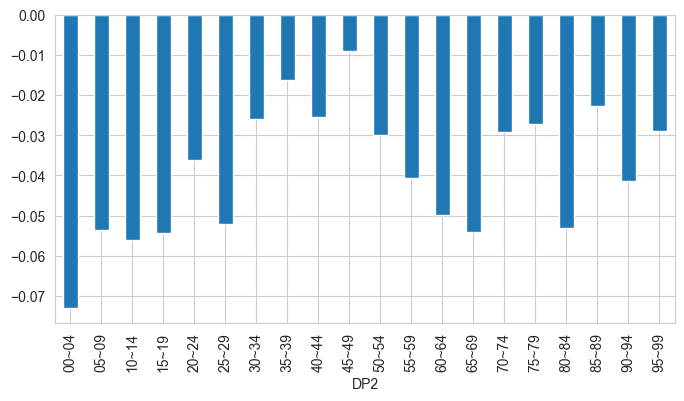

,观测数,C2C_均值,C2C_中位数,C2C_t值,C2O_均值,C2O_中位数,C2O_t值
DP2,,,,,,,
00~04,3337536,-0.022%,-0.245%,-17.14,0.051%,0.011%,87.34
05~09,3118016,-0.026%,-0.223%,-20.15,0.028%,0.006%,48.79
10~14,3085440,-0.015%,-0.232%,-11.70,0.041%,0.003%,68.85
15~19,3227584,-0.024%,-0.221%,-19.09,0.030%,0.006%,55.11
20~24,2940864,-0.008%,-0.234%,-5.69,0.029%,0.003%,48.00
25~29,3081472,-0.042%,-0.244%,-32.62,0.010%,-0.010%,17.40
30~34,2955136,0.005%,-0.238%,3.88,0.031%,-0.004%,51.37
35~39,2994176,-0.001%,-0.234%,-0.58,0.016%,-0.010%,25.19
40~44,2902592,0.010%,-0.229%,7.51,0.036%,-0.001%,57.13


In [17]:
df = pd.read_excel(src_path + '价格尾数（毛、分位）与随后的股票收益率.xlsx', index_col=0)

((df['C2C_均值'] - df['C2O_均值']) * 100).plot.bar(); plt.show()
# df['频率'] = (df['观测数'] / df['观测数'].sum())
# df = df[['观测数', '频率', 'C2C_均值', 'C2C_中位数', 'C2C_t值', 'C2O_均值', 'C2O_中位数', 'C2O_t值']]
df_repr = df.applymap(lambda x: f'{x*100:2.3f}%' if abs(x) < 0.01 else round(x, 2) if isinstance(x, float) else x)
# print(df_repr.to_markdown())
df_repr